In [103]:
import gzip
import pandas as pd
import os
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Functions

In [52]:
def parse(file_path:str, data_columns:list,annotations_columns:list) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Parameters
    ----------
    file_path : str
        The path to location of the data
    data_columns : list
        The list of columns' names for the text data - abstract, title
    annotations_columns : list
        The list of columns' names for annotation data

    Returns

    -------
    tuple of DataFrames
        data - with texts of abstracts and titles
        annotations - with annotations 
        errors - records that did not fit to the data or annotations
    """  
    data = pd.DataFrame(columns = data_columns)
    annotations = pd.DataFrame(columns = annotations_columns)
    errors = pd.DataFrame()
    # hardcoded
    HEADER = re.compile(r"(?P<PMID>[0-9]*)\|(?P<Type>[t|a])\|(?P<Content>.*)")
    with gzip.open(file_path, 'rb') as f:
        i = 0
        for line in tqdm(f.readlines()):
            i+=1
            l = line.decode("utf-8")
            if l == '\n':
                continue
            h = HEADER.match(l)
            if h:
                data = pd.concat([data,pd.DataFrame([{k:h.group(k) for k in data_columns}])], ignore_index=True)
            else:
                _ = l.split('\t')
                if len(_) == len(annotations_columns):
                    annotations = pd.concat([annotations,pd.DataFrame([dict(zip(annotations_columns,_))])], ignore_index=True)
                else:
                    errors = pd.concat([errors,pd.DataFrame([l])],ignore_index=True)
    return data, annotations,errors

In [125]:
def draw_histogram(data,title, xlabel, ylabel, legend = [], bins_number = 20):
     fig, ax = plt.subplots(1,1,figsize =(10,5))
     g1 = sns.histplot(data = data, ax = ax, bins = bins_number)
     plt.legend(legend, frameon=False)
     g1.set(title = title, xlabel =xlabel, ylabel = ylabel )
     plt.show()

# Getting data

# ST21pv
- eliminate all concepts that were only linked to semantic types at levels 1 or 2 ( too broad )
- selected 21 semantic types at level 3-5 relevant and have enough occurences ( only concepts mapping into one of
these 21 types [ or to a descendant] )
- excluded any concepts that were not linked in UMLS to at least one of 18 preffered vocabluary sources
- 25,419 unique concepts mentioned
- 203,282 concept mentions
- 4392 documents



In [55]:
folder = 'data'
file_name = 'corpus_pubtator.txt.gz'

In [56]:
data_columns = ['PMID', 'Type','Content']
annotations_columns = ['PMID', 'StartIndex','EndIndex','MentionTextSegment','SemanticTypeID','EntityID']


In [57]:
data_21, annotations_21,errors_21 = parse(os.path.join(folder,file_name), data_columns, annotations_columns)

100%|██████████| 216458/216458 [43:08<00:00, 83.62it/s]  


### Data cleaning

In [157]:
semantic_mapping = pd.read_csv(os.path.join(folder, 'semantic_type_mapping.txt'), sep = '|', header=None)[[1,2]]
semanitc_mapper = dict(zip(semantic_mapping[1],semantic_mapping[2] ))

In [158]:
annotations_21['EntityID'] = annotations_21['EntityID'].apply(lambda x : x.replace('\n',''))
annotations_21['SemanticMeaning'] = annotations_21['SemanticTypeID'].apply(lambda x : semanitc_mapper[x])

### Checking if numbers in paper are correct

In [159]:
print(f" Number of records in errors {len(errors_21)}")

 Number of records in errors 0


In [160]:
_ = data_21['PMID'].value_counts()
print(f"Number of documents {len(_)} in documents_21, does all have both title and abstract {sum(_ == 2) == len(_)}")

Number of documents 4392 in documents_21, does all have both title and abstract True


In [161]:
print(f"Number of documents in annotations_21: {len(annotations_21['PMID'].unique())}")

Number of documents in annotations_21: 4392


In [162]:
print(f"Number of semantic types in annotations_21: {len(annotations_21['SemanticMeaning'].unique())}")

Number of semantic types in annotations_21: 21


In [163]:
print(f"Number of unique concept metions in annotations_21: {len(annotations_21['EntityID'].unique())}")

Number of unique concept metions in annotations_21: 25419


In [164]:
print(f"Number of all concept metions in annotations_21: {len(annotations_21)}")

Number of all concept metions in annotations_21: 203282


### Basic Statistics 

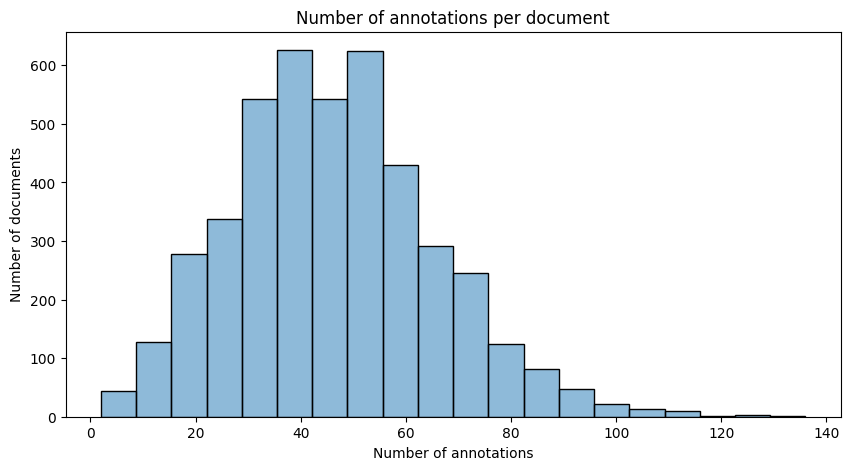

In [165]:
annots_per_documents = annotations_21.groupby('PMID').agg({'StartIndex ':len})
draw_histogram(annots_per_documents,'Number of annotations per document', 'Number of annotations', 'Number of documents')

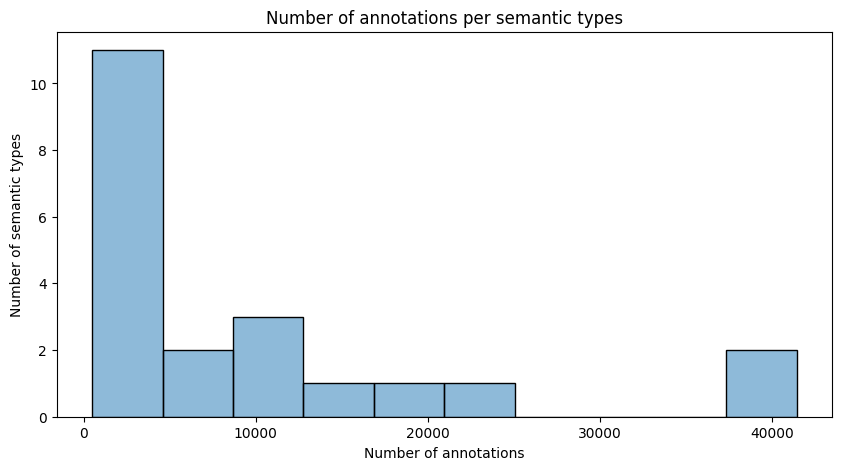

In [166]:
annots_per_sem = annotations_21.groupby('SemanticMeaning').agg({'StartIndex ':len})
draw_histogram(annots_per_sem,'Number of annotations per semantic types', 'Number of annotations', 'Number of semantic types', bins_number=10)

In [167]:
annots_per_sem.sort_values(by = "StartIndex ", ascending=False)

,StartIndex
SemanticMeaning,
Biologic Function,41422
Chemical,37401
Health Care Activity,24306
Anatomical Structure,20497
Finding,16227
Spatial Concept,12500
Intellectual Product,10324
Research Activity,9172
Eukaryote,8543


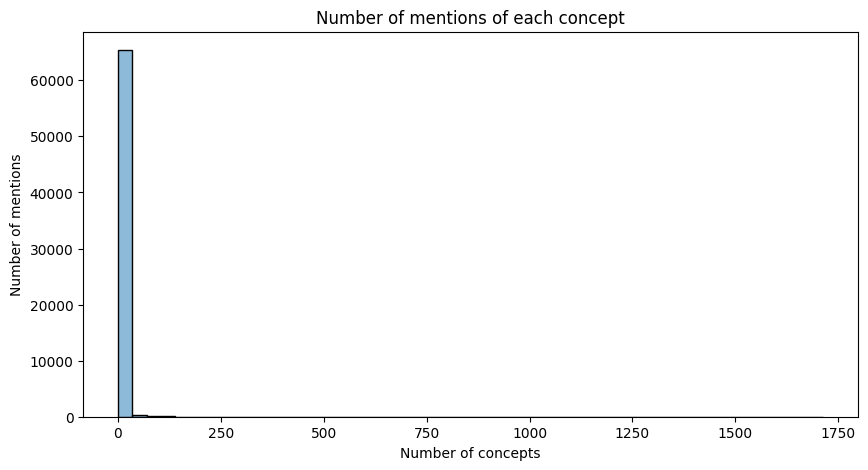

In [170]:
annots_per_type = annotations_21.groupby('MentionTextSegment').agg({'StartIndex ':len})
draw_histogram(annots_per_type,'Number of mentions of each concept', 'Number of concepts', 'Number of mentions', bins_number=50)

In [171]:
annots_per_type.sort_values(by = "StartIndex ", ascending=False)

,StartIndex
MentionTextSegment,
study,1713
expression,799
treatment,763
women,549
human,504
...,...
arousal system,1
arousals,1
array CGH,1


# Saving raw data

In [175]:
annotations_21.to_csv(os.path.join(folder,"annotations_21_raw.csv"))
data_21.to_csv(os.path.join(folder,"titles_and_abstracts_raw.csv"))

# Data Cleaning

In [199]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

## sentences

In [182]:
data_21['tokenized_sentences'] = data_21['Content'].apply(lambda text : nltk.sent_tokenize(text))

## words
- format: list of lists

In [ ]:
def process(sentence: list) -> list:
    """
    takes list of tokens and returns steamed tokens without stopwords
    """

In [194]:
# decided to tokenize words in tokenized sentences -> I think it would be more useful and easy to change
data_21['tokenized_words'] = None
data_21['tokenized_words_processed'] = None
for index, row in data_21.iterrows():
    tokens = []
    tokens_no_stop = []
    for sentence in row['tokenized_sentences']:
        tokens.append(nltk.word_tokenize(sentence))
    data_21.loc[index,'tokenized_words']  = tokens
        

## Stop words removal

In [ ]:
data_21['abstract_no_stop_words'] = data_21['abstract'].apply(lambda x: ' '.join([w for w in x.split(' ') if not w.lower() in stopwords]))